In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')

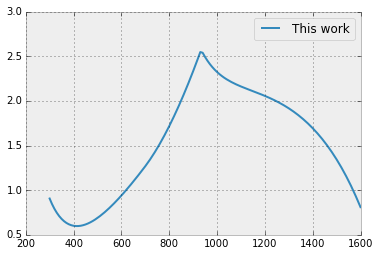

In [23]:
import json
import numpy as np
import xray
from pycalphad import calculate, Model, Database
from pycalphad.core.utils import make_callable
import pycalphad.variables as v
import itertools
import functools
from collections import OrderedDict
from sympy import Symbol
def setup_dataset(file_obj, dbf, params):
    # params should be a list of pymc3 variables corresponding to parameters
    data = json.load(file_obj)
    if data['solver']['mode'] != 'manual':
        raise NotImplemented
    fit_models = {name: Model(dbf, data['components'], name) for name in data['phases']}
    #params = sorted(params, key=str)
    param_vars = []
    for key, mod in fit_models.items():
        param_vars.extend(sorted(set(mod.ast.atoms(Symbol)) - set(mod.variables), key=str))
    param_vars = sorted(param_vars)
    if len(params) != len(param_vars):
        raise ValueError('Input parameter vector length doesn\'t match the free parameters in the phase models: {0} != {1}'.format(len(params), len(param_vars)))
    indep_vars = [v.P, v.T]
    site_fracs = {key: sorted(mod.ast.atoms(v.SiteFraction), key=str) for key, mod in fit_models.items()} 
    # Call this from a routine that pulls in all datasets and generates the variance vars + Potentials
    callables = {name: make_callable(getattr(mod, data['output']),
                                     itertools.chain(param_vars, indep_vars, site_fracs[name]))
                 for name, mod in fit_models.items()}
    extra_conds = OrderedDict({key: np.atleast_1d(value) for key, value in data['conditions'].items()})
    exp_values = xray.DataArray(np.array(data['values'], dtype=np.float)[..., None],
                                dims=list(extra_conds.keys())+['points'], coords=extra_conds)
    def compute(*args):
        prefill_callables = {key: functools.partial(*itertools.chain([func],args[:len(params)])) for key, func in callables.items()}
        result = calculate(dbf, data['components'], data['phases'], output=data['output'],
                       points=np.atleast_2d(data['solver']['sublattice_configuration']).astype(np.float),
                       callables=prefill_callables, model=fit_models, **extra_conds)
        error = (result[data['output']] - exp_values).sel(T=slice(300, None)).values.flatten() # Eliminate data below 300 K for now
        return error, result, exp_values
    return compute
dataset_func = setup_dataset(open('Al-Ni/Ni3Al-CPM.json'), Database('Al-Ni/Al-Ni-Dupin-2001.tdb'), [])
plt.plot(np.arange(300, 1601, 10), dataset_func()[0], label='This work')
#plt.plot(np.array(data['conditions']['T']), dft_values, color='black', label='Y. Wang 2009 (DFT)')
plt.legend(loc='best')
plt.show()

In [ ]:
from pycalphad import Database, equilibrium
import pycalphad.variables as v
dbf_start = Database('Al-Ni/Al-Ni-start.tdb')
dbf_dupin = Database('Al-Ni/Al-Ni-Dupin-2001.tdb')
#phases = ['FCC_L12', 'BCC_B2', 'LIQUID', 'AL3NI1', 'AL3NI2', 'AL3NI5']
ni3al_dupin = equilibrium(dbf_dupin, ['NI', 'AL', 'VA'], 'FCC_L12', {v.T: 1400, v.P: 101325, v.X('AL'): .250001})
print(ni3al_dupin.Y)
print(ni3al_dupin.X)
print(ni3al_dupin.NP)
#ni3al_start = equilibrium(dbf_start, ['NI', 'AL', 'VA'], 'FCC_L12', {v.T: (0, 1600, 100), v.P: 101325, v.X('AL'): .25})

In [ ]:
import numpy as np
# Binary solution
def energy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return 8.3145*T*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (H_ex - T*S_ex+L2_ex*T**2)*x_a*x_b

def entropy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return -(8.3145*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (-S_ex + 2*T*L2_ex)*x_a*x_b)

def heat_capacity(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return -(2*T*L2_ex)*x_a*x_b

def enthalpy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return energy(H_ex, S_ex, L2_ex, T, x_a, x_b) + T*entropy(H_ex, S_ex, L2_ex, T, x_a, x_b)

In [ ]:
import numpy as np
rng = np.random.RandomState(1769)

# True model parameters, known only by nature
true_H_ex = 7e3
true_S_ex = 5
true_L2_ex = 0

# Some generated "observed" data
# Dataset 1
n1 = 10
dataset1 = {
'n': n1,
'x_a': rng.random_sample((n1,)),
'T': rng.uniform(300, 2000, size=(n1,)),
'func': entropy
}
dataset1['x_b'] = 1 - dataset1['x_a']
# Dataset 2
n2 = 10
dataset2 = {
'n': n2,
'x_a': rng.random_sample((n2,)),
'T': rng.uniform(300, 2000, size=(n2,)),
'func': enthalpy
}
dataset2['x_b'] = 1 - dataset2['x_a']
# Dataset 3
n3 = 10
dataset3 = {
'n': n3,
'x_a': rng.random_sample((n3,)),
'T': 500,
'func': entropy
}
dataset3['x_b'] = 1 - dataset3['x_a']
# Dataset 4
n4 = 10
dataset4 = {
'n': n4,
'x_a': rng.random_sample((n4,)),
'T': 900,
'func': enthalpy
}
dataset4['x_b'] = 1 - dataset4['x_a']
# Dataset 5
n5 = 10
dataset5 = {
'n': n5,
'x_a': rng.random_sample((n5,)),
'T': 1000,
'func': entropy
}
dataset5['x_b'] = 1 - dataset5['x_a']
# Dataset 6
n6 = 10
dataset6 = {
'n': n6,
'x_a': rng.random_sample((n6,)),
'T': 1200,
'func': enthalpy
}
dataset6['x_b'] = 1 - dataset6['x_a']
# Dataset 7
n7 = 10
dataset7 = {
'n': n7,
'x_a': rng.random_sample((n7,)),
'T': 1400,
'func': entropy
}
dataset7['x_b'] = 1 - dataset7['x_a']
# Dataset 8
n8 = 10
dataset8 = {
'n': n8,
'x_a': rng.random_sample((n8,)),
'T': 1600,
'func': enthalpy
}
dataset8['x_b'] = 1 - dataset8['x_a']
# Dataset 9
n9 = 10
dataset9 = {
'n': n9,
'x_a': rng.random_sample((n9,)),
'T': 1800,
'func': entropy
}
dataset9['x_b'] = 1 - dataset9['x_a']
# Dataset 10
n10 = 10
dataset10 = {
'n': n10,
'x_a': rng.random_sample((n10,)),
'T': 1900,
'func': enthalpy
}
dataset10['x_b'] = 1 - dataset10['x_a']

# Observed quantities: true value plus noise
noise1 = rng.normal(0, 0.1, size=dataset1['n'])
noise2 = rng.normal(0, 10, size=dataset2['n'])
noise3 = rng.normal(0, 0.1, size=dataset3['n'])
noise4 = rng.normal(0, 10, size=dataset4['n'])
noise5 = rng.normal(0, 0.1, size=dataset5['n'])
noise6 = rng.normal(0, 10, size=dataset6['n'])
noise7 = rng.normal(0, 0.1, size=dataset7['n'])
noise8 = rng.normal(0, 10, size=dataset8['n'])
noise9 = rng.normal(10, 0.1, size=dataset9['n'])
noise10 = rng.normal(-1000, 10, size=dataset10['n'])
dataset1['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset1['T'], dataset1['x_a'], dataset1['x_b']) + noise1
dataset2['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset2['T'], dataset2['x_a'], dataset2['x_b']) + noise2
dataset3['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset3['T'], dataset3['x_a'], dataset3['x_b']) + noise3
dataset4['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset4['T'], dataset4['x_a'], dataset4['x_b']) + noise4
dataset5['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset5['T'], dataset5['x_a'], dataset5['x_b']) + noise5
dataset6['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset6['T'], dataset6['x_a'], dataset6['x_b']) + noise6
dataset7['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset7['T'], dataset7['x_a'], dataset7['x_b']) + noise7
dataset8['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset8['T'], dataset8['x_a'], dataset8['x_b']) + noise8
dataset9['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset9['T'], dataset9['x_a'], dataset9['x_b']) + noise9
dataset10['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset10['T'], dataset10['x_a'], dataset10['x_b']) + noise10
datasets = [dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7, dataset8, dataset9, dataset10]

In [ ]:
# Priors on unknown parameters
from pymc3 import Normal, Gamma, Potential, sample, Model, NUTS, find_MAP
with Model() as phase_model:
    H_ex = Normal('H_ex', mu=0, sd=1000)
    S_ex = Normal('S_ex', mu=0, sd=50)
    L2_ex = Normal('L2_ex', mu=0, sd=10)
    ds_var = Gamma('ds_var', alpha=np.full_like(datasets, 0.1, dtype=np.float), beta=np.full_like(datasets, 0.1, dtype=np.float), shape=len(datasets))
    # datasets is defined elsewhere
    e = []
    for idx, dataset in enumerate(datasets):
        e.append(Potential('e_{}'.format(idx), -(np.square(dataset['func'](H_ex, S_ex, L2_ex, dataset['T'], dataset['x_a'], dataset['x_b']) - dataset['value'])).mean() / ds_var[idx]))

In [ ]:
from pymc3 import Metropolis, find_MAP
with phase_model:
    #start = find_MAP()
    step = Metropolis()
    full_trace = sample(100000, step, progressbar=True)
    burnin = 80000
    thin = 2
    trace = full_trace[burnin::thin]

In [ ]:
from pymc3 import summary, autocorrplot, traceplot
summary(trace, vars=['H_ex', 'S_ex', 'L2_ex'])
autocorrplot(trace, vars=['H_ex', 'S_ex', 'L2_ex'])
plt.show()

In [ ]:
traceplot(trace)
plt.show()

In [ ]:
%matplotlib inline
from corner import corner
from itertools import chain
data = np.vstack(chain([trace['H_ex'], trace['S_ex'], trace['L2_ex']])).T
corner(data, labels=[r"$H_{ex}$", r"$S_{ex}$", r"$L^2_{ex}$"],
       truths=[true_H_ex, true_S_ex, true_L2_ex],
       quantiles=[0.16, 0.5, 0.84],
       show_titles=True, title_args={"fontsize": 40}).show()

In [ ]:
S_ex_tr, H_ex_tr = (trace['S_ex'], trace['H_ex'])
Tfit = np.linspace(300, 2000, 100)
Efit = energy(H_ex_tr[:, None], S_ex_tr[:, None], trace['L2_ex'][:, None], Tfit, 0.5, 0.5)
true_y = energy(true_H_ex, true_S_ex, true_L2_ex, Tfit, 0.5, 0.5)
mu = Efit.mean(axis=0)
sigma = 2 * Efit.std(axis=0)
plt.plot(Tfit, mu, '-k')
plt.plot(Tfit, true_y, '--')
plt.fill_between(Tfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlabel('T')
plt.ylabel('Molar Gibbs Energy at x_a=0.5')

In [ ]:
temp = 300 # temperature of interest

In [ ]:
S_ex_tr, H_ex_tr = (trace['S_ex'], trace['H_ex'])
Tfit = np.linspace(300, 2000, 100)
Cfit = heat_capacity(H_ex_tr[:, None], S_ex_tr[:, None], trace['L2_ex'][:, None], Tfit, 0.5, 0.5)
true_y = heat_capacity(true_H_ex, true_S_ex, true_L2_ex, Tfit, 0.5, 0.5)
mu = Cfit.mean(axis=0)
sigma = 2 * Cfit.std(axis=0)
plt.plot(Tfit, mu, '-k')
plt.plot(Tfit, true_y, '--')
plt.fill_between(Tfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlabel('T')
plt.ylabel('Molar Heat Capacity at x_a=0.5')

In [ ]:
S_ex_tr, H_ex_tr = (trace['S_ex'], trace['H_ex'])
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = energy(H_ex_tr[:, None], S_ex_tr[:, None], trace['L2_ex'][:, None], temp, xfit, 1-xfit)
true_y = energy(true_H_ex, true_S_ex, true_L2_ex, temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sigma = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.plot(xfit, true_y, '--')
plt.fill_between(xfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlim(0,1)
plt.xlabel('x_a')
plt.ylabel('Molar Gibbs Energy at T = {} K'.format(temp))

In [ ]:
S_ex_tr, H_ex_tr = (trace['S_ex'], trace['H_ex'])
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = entropy(H_ex_tr[:, None], S_ex_tr[:, None], trace['L2_ex'][:, None], temp, xfit, 1-xfit)
true_y = entropy(true_H_ex, true_S_ex, true_L2_ex, temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sigma = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.plot(xfit, true_y, '--')
plt.fill_between(xfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Entropy at T = {} K'.format(temp))

In [ ]:
S_ex_tr, H_ex_tr = (trace['S_ex'], trace['H_ex'])
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = enthalpy(H_ex_tr[:, None], S_ex_tr[:, None], trace['L2_ex'][:, None], temp, xfit, 1-xfit)
true_y = enthalpy(true_H_ex, true_S_ex, true_L2_ex, temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sigma = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.plot(xfit, true_y, '--')
plt.fill_between(xfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Enthalpy at T = {} K'.format(temp))